# 03: Fit KMeans and Profile Clusters

## Objectives

- Fit final KMeans on all rows with k=chosen_k.
- Save model to `artifacts/models/kmeans.joblib`.
- Attach labels to the cleaned DataFrame and create readable cluster profiles.


In [10]:
# === TODO ===
# Fit final model; persist with joblib; append labels to DataFrame.
# Acceptance: artifacts/models/kmeans.joblib exists; df has 'cluster' column

import sys
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import joblib

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.prep import basic_clean

# Load and preprocess data (same as notebook 02)
path = "../data/raw/CC GENERAL.csv"
df = pd.read_csv(path)

# Convert CUST_ID to int and drop it (identifier, not useful for clustering)
df["CUST_ID"] = df["CUST_ID"].str.split("C", expand=True)[1]
df["CUST_ID"] = df["CUST_ID"].astype(int)

# Clean the data
df = basic_clean(df).drop(columns=["CUST_ID"])

# Scale the data (same as notebook 02)
scaler = StandardScaler()
X_ready = scaler.fit_transform(df)

# Use chosen k from previous notebook
chosen_k = 3
kmeans = KMeans(n_clusters=chosen_k, n_init='auto', random_state=42)
kmeans.fit(X_ready)
labels = kmeans.labels_

# Add cluster labels to the DataFrame
df['cluster'] = labels

# Verify the cluster column was created
print(f"DataFrame shape: {df.shape}")
print(f"Cluster column created: {'cluster' in df.columns}")
print(f"Cluster distribution:\n{df['cluster'].value_counts().sort_index()}")

# Create artifacts/models directory if it doesn't exist
os.makedirs('../artifacts/models', exist_ok=True)

# Save the model
model_path = '../artifacts/models/kmeans.joblib'
joblib.dump(kmeans, model_path)
print(f"\nModel saved to: {model_path}")
print(f"Model file exists: {os.path.exists(model_path)}")




DataFrame shape: (8950, 18)
Cluster column created: True
Cluster distribution:
cluster
0    3218
1    2897
2    2835
Name: count, dtype: int64

Model saved to: ../artifacts/models/kmeans.joblib
Model file exists: True


In [11]:
print(df.columns)

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE', 'cluster'],
      dtype='object')


In [13]:
# === TODO ===
# Build a profile table: per-cluster size, feature means, and z-scores vs global.
# Hints: viz.cluster_profile_table
# Acceptance: printed table sorted by cluster size; brief text naming clusters (e.g., "High-balance low-pay")
from src.viz import cluster_profile_table

# Build profile table
feature_list = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
                'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
                'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
                'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
                'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
                'TENURE']

profile = cluster_profile_table(df, feature_list)

print(profile)



   cluster  size  BALANCE_mean  BALANCE_zscore  BALANCE_FREQUENCY_mean  \
0        0  3218      7.051718        0.443968                0.682658   
1        1  2897      4.113084       -1.019395                0.529468   
2        2  2835      7.240028        0.537742                0.643654   

   BALANCE_FREQUENCY_zscore  PURCHASES_mean  PURCHASES_zscore  \
0                  0.425592        7.242993          0.806906   
1                 -0.626974        5.577892          0.234647   
2                  0.157598        1.532412         -1.155696   

   ONEOFF_PURCHASES_mean  ONEOFF_PURCHASES_zscore  ...  CREDIT_LIMIT_mean  \
0               5.856334                 0.820694  ...           8.389211   
1               2.157305                -0.321916  ...           7.811602   
2               1.248595                -0.602611  ...           8.053531   

   CREDIT_LIMIT_zscore  PAYMENTS_mean  PAYMENTS_zscore  MINIMUM_PAYMENTS_mean  \
0             0.361646       7.368446         0.4725

Mean Silhouette Score per Cluster:
cluster
0    0.185832
1    0.157060
2    0.353520
Name: silhouette_score, dtype: float64

Overall mean silhouette: 0.2296


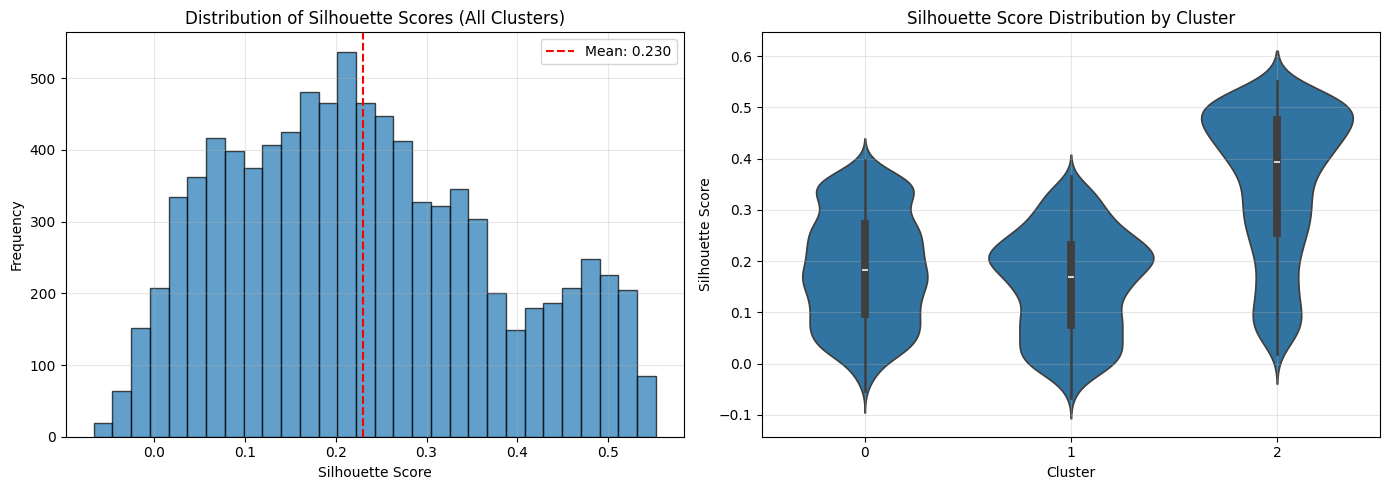


=== Interpretation ===
Silhouette scores range from -1 to +1:
- Values close to +1: Points are well-matched to their cluster
- Values close to 0: Points are on the boundary between clusters
- Values close to -1: Points may be assigned to the wrong cluster

Overall mean silhouette of 0.230 indicates reasonable cluster separation.


In [15]:
# === TODO ===
# Sanity: compute per-cluster Silhouette scores (sample-level) and show distribution.
# Hints: sklearn.metrics.silhouette_samples
# Acceptance: histogram/violin of silhouette by cluster; 1–2 lines of interpretation

from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Compute Silhouette scores for each sample (one score per data point)
silhouette_scores = silhouette_samples(X_ready, df['cluster'])

# Add silhouette scores to the original DataFrame (not the profile table)
df['silhouette_score'] = silhouette_scores

# Compute mean silhouette per cluster for the profile table
mean_silhouette_per_cluster = df.groupby('cluster')['silhouette_score'].mean()
profile['mean_silhouette'] = profile['cluster'].map(mean_silhouette_per_cluster)

print("Mean Silhouette Score per Cluster:")
print(mean_silhouette_per_cluster)
print(f"\nOverall mean silhouette: {silhouette_scores.mean():.4f}")

# Create visualization directory if needed
os.makedirs('../images', exist_ok=True)

# Create subplot with histogram and violin plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of all silhouette scores
axes[0].hist(silhouette_scores, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(silhouette_scores.mean(), color='red', linestyle='--', 
                label=f'Mean: {silhouette_scores.mean():.3f}')
axes[0].set_title('Distribution of Silhouette Scores (All Clusters)')
axes[0].set_xlabel('Silhouette Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Violin plot by cluster
sns.violinplot(data=df, x='cluster', y='silhouette_score', ax=axes[1])
axes[1].set_title('Silhouette Score Distribution by Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/silhouette_scores.png', dpi=150, bbox_inches='tight')
plt.show()

# Interpretation
print("\n=== Interpretation ===")
print("Silhouette scores range from -1 to +1:")
print("- Values close to +1: Points are well-matched to their cluster")
print("- Values close to 0: Points are on the boundary between clusters")
print("- Values close to -1: Points may be assigned to the wrong cluster")
print(f"\nOverall mean silhouette of {silhouette_scores.mean():.3f} indicates reasonable cluster separation.")

